In [31]:
# !pip install torch==1.11.0
# !pip install torchvision==0.12.0
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl

# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version 1.11 --apt-packages libomp5 libopenblas-dev

# on TPU
# !pip install torch==1.9.0
!pip install torchvision==0.10.0
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
    
!pip install git+https://github.com/fbcotter/pytorch_wavelets 

#!pip install cloud-tpu-client --upgrade

    
# import maths
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from numpy.random import randint  

import os
import csv

import glob
import matplotlib.pyplot as plt
from collections import namedtuple
from copy import deepcopy
from tqdm import tqdm
import random

import cv2

# pytorch + torchvision
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter 
import torch.nn.functional as F

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.io as io

import kornia

# Check that you're using a recent OpenCV version.
assert cv2.__version__ > '4.5', 'Please use OpenCV 4.5 or later.'

print (sys.version)

  Using cached https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl (149.9 MB)
  Cloning https://github.com/fbcotter/pytorch_wavelets to /tmp/pip-req-build-o1gnd2k4
  Running command git clone -q https://github.com/fbcotter/pytorch_wavelets /tmp/pip-req-build-o1gnd2k4
  Resolved https://github.com/fbcotter/pytorch_wavelets to commit 8d2e3b4289beaea9aa89f7b1dbb290e448331197
3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0]


Write down the plan in words and references. We will then fill in code.

In [ ]:
# Encoding: ResNeXt (conv 1-3) => Position Enc. (ref. 2107.14222) => Deep-ViT (w/ EfficientNet)
# Decoding(for unsupervised training) : HiT(low resolution stage, same # as Deep-ViT) => FCC-GAN
# Comparison : Transformer-XL 
# Classifier/MLP : MLP head (output 8) => Reconstruction module => F

# Training Steps:
# 1. Train Encoder (unsupervised): manipulate input image (ref. SiT, + rotation) and match to output
# 2. Train Comparison (unsupervised) : use different head, mix&match the 2 images (ref. BERT, ALBERT)
# 3. Train MLP (supervised) : compare output to F

# Inference Steps: Encode each image => concat. 2 images => Comparison => MLP

#offical sample code: https://www.kaggle.com/code/eduardtrulls/imc2022-training-data?scriptVersionId=92062607

# Load data

In [32]:
# copied from sample code
# Input data files are available in the read-only "../input/" directory.

# on kaggle
src = '../input/image-matching-challenge-2022/train'

# on pc
# src = './image-matching-challenge-2022/train'

val_scenes = []
for f in os.scandir(src):
    if f.is_dir():
        cur_scene = os.path.split(f)[-1]
        print(f'Found scene "{cur_scene}"" at {f.path}')
        val_scenes += [cur_scene]

Found scene "british_museum"" at ../input/image-matching-challenge-2022/train/british_museum
Found scene "piazza_san_marco"" at ../input/image-matching-challenge-2022/train/piazza_san_marco
Found scene "trevi_fountain"" at ../input/image-matching-challenge-2022/train/trevi_fountain
Found scene "st_pauls_cathedral"" at ../input/image-matching-challenge-2022/train/st_pauls_cathedral
Found scene "colosseum_exterior"" at ../input/image-matching-challenge-2022/train/colosseum_exterior
Found scene "buckingham_palace"" at ../input/image-matching-challenge-2022/train/buckingham_palace
Found scene "temple_nara_japan"" at ../input/image-matching-challenge-2022/train/temple_nara_japan
Found scene "sagrada_familia"" at ../input/image-matching-challenge-2022/train/sagrada_familia
Found scene "grand_place_brussels"" at ../input/image-matching-challenge-2022/train/grand_place_brussels
Found scene "pantheon_exterior"" at ../input/image-matching-challenge-2022/train/pantheon_exterior
Found scene "notre

In [ ]:
# Each scene in the validation set contains a list of images, poses, and pairs. Let's pick one and look at some images.
'''
scene = 'piazza_san_marco'

images_dict = {}
for filename in glob(f'{src}/{scene}/images/*.jpg'):
    cur_id = os.path.basename(os.path.splitext(filename)[0])

    # OpenCV expects BGR, but the images are encoded in standard RGB, so you need to do color conversion if you use OpenCV for I/O.
    images_dict[cur_id] = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    
print(f'Loaded {len(images_dict)} images.')

num_rows = 6
num_cols = 4
f, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20), constrained_layout=True)
for i, key in enumerate(images_dict):
    if i >= num_rows * num_cols:
        break
    cur_ax = axes[i % num_rows, i // num_rows]
    cur_ax.imshow(images_dict[key])
    cur_ax.set_title(key)
    cur_ax.axis('off')
'''

In [ ]:
#resize the image

In [34]:
# dataset
from torch.utils.data import Dataset

# this loads 2 imgs at once for the first 2 training steps
class IMC_images(Dataset):

    def __init__(self, landmarks, root_dir, transform=lambda x : x):
        self.landmarks = landmarks
        self.root_dir = root_dir
        self.transform = transform
        
        self.buffer_data()

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        landmark1 = random.randint(0, len(self.imgs.keys())-1)
        landmark2 = random.randint(0, len(self.imgs.keys())-1)

        img_num1 = random.randint(0, len(self.imgs[landmark1]))
        img_num2 = random.randint(0, len(self.imgs[landmark2]))

        img1 = self.imgs[landmark1][img_num1]
        img2 = self.imgs[landmark2][img_num2]

        comp = []
        if landmark1 == landmark2 :
            comp = [1, 0]
        else :
            comp = [0, 1]
        
        if img_num1 == img_num2 :
            comp.append(1)
        else :
            comp.append(0)
        
        sample = {'img1': img1, 'img2': img2, 'comp': comp}

        return sample
    
    def buffer_data(self):
        self.imgs = {}
        for i, j in enumerate(self.landmarks[:1]):
            imgs = []
            for file in glob.glob(self.root_dir + "/" + j + '/images/*'):
                x = self.transform(io.read_image(file, mode=io.ImageReadMode.RGB))
                imgs.append(x)
            print(len(imgs))
            self.imgs[i] = torch.stack((*imgs,), 0)
                # Length * Height * Width
    

# dataset
class IMC_dataset(Dataset):
    """Image Matching Challenge 2022 dataset"""

    def __init__(self, cali_file, covis_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.calibration = pd.read_csv(cali_file)
        self.pair_covisibility = pd.read_csv(covis_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.pair_covisibility)

    def __getitem__(self, idx):
        """
        Returns:
            image_1 (tensor): First image
            image_2 (tensor): Secound image
            covisibility (float)
            K_1 (matrix): Camera intransic matrix
            K_2 (matrix): Camera intransic matrix
            R_1 (matrix): Rotation matrix
            R_2 (matrix): Rotation matrix
            T_1 (vector): Translation vector
            T_2 (vector): Translation vector
            F (matrix): Fundamental matrix
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        pairID = self.pair_covisibility["pair"][idx]

        img_1_id , img_2_id = pairID.split("-")

        F = self.pair_covisibility["fundamental_matrix"][idx]

#         print(img_1_id, img_2_id) 

        img_1 = io.read_image(os.path.join(root_dir, img_1_id) + ".jpg")
        img_2 = io.read_image(os.path.join(root_dir, img_2_id) + ".jpg")

        covis = self.pair_covisibility["covisibility"][idx]

        idx_1 = self.calibration.loc[self.calibration['image_id'] == img_1_id]
        idx_2 = self.calibration.loc[self.calibration['image_id'] == img_2_id]

        K_1 = self.calibration['camera_intrinsics'][idx_1]
        K_2 = self.calibration['camera_intrinsics'][idx_2]

        R_1 = self.calibration['rotation_matrix'][idx_1]
        R_2 = self.calibration['rotation_matrix'][idx_2]

        T_1 = self.calibration['translation_vector'][idx_1]
        T_2 = self.calibration['translation_vector'][idx_2]

        sample = {'img_1': img_1, 'img_2': img_2, 'img_2': img_2, 'img_2': img_2, \
         'covisibility': covis, 'K_1': K_1, 'K_2': K_2, 'R_1': R_1, 'R_2': R_2, \
         'T_1': T_1, 'T_2': T_2, "F": F}

        if self.transform:
            sample = self.transform(sample)

        return sample
        
# cali_file = '.\\image-matching-challenge-2022\\train\\brandenburg_gate\\calibration.csv'
# covis_file = ".\\image-matching-challenge-2022\\train\\brandenburg_gate\\pair_covisibility.csv"
# root_dir = ".\\image-matching-challenge-2022\\train\\brandenburg_gate\\images"

cali_file = src + '/brandenburg_gate/calibration.csv'
covis_file = src + '/brandenburg_gate/pair_covisibility.csv'
root_dir = src + '/brandenburg_gate/images'

dataset = IMC_dataset(cali_file, covis_file, root_dir)

def rot_resize(x):
    s = x.size()
    if s[0] > s[1] :
        return torchvision.transforms.Resize((512, 384))(x)
    else :
        return torchvision.transforms.Resize((384, 512))(x)

def test_imc_img():
    imc_imgs = IMC_images(
        val_scenes, src, 
        transform=rot_resize
    )
    sample = imc_imgs.__getitem__(0)
    return sample["img1"]

print(test_imc_img().size())


176
torch.Size([3, 384, 512])


In [ ]:
# # pytorch data loading
# def get_scene_trainloader(scene):

#     transform = transforms.Compose(
#         [transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#     trainset = "./image-matching-challenge-2022/train/" + scene

#     trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
#                                             shuffle=True, num_workers=2)

#     classes = ('plane', 'car', 'bird', 'cat',
#             'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#     def imshow(img):
#         img = img / 2 + 0.5     # unnormalize
#         npimg = img.numpy()
#         plt.imshow(np.transpose(npimg, (1, 2, 0)))


#     # get some random training images
#     dataiter = iter(trainloader)

#     print(dataiter.next())
#     images, labels = dataiter.next()

#     # show images
#     imshow(torchvision.utils.make_grid(images))
#     # print labels
#     print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#     return trainloader

# get_scene_trainloader("piazza_san_marco")

176
torch.Size([1, 3, 384, 512])


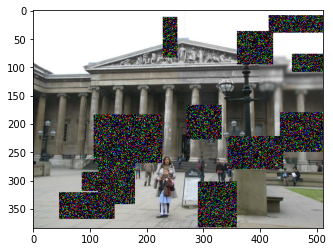

In [35]:
# image manipulation (ref. SiT)
# paper:
# github: github.com/Sara-Ahmed/SiT
# Copy + Pasted from the github 

def drop_rand_patches(X, X_rep=None, max_drop=0.3, max_block_sz=0.25, tolr=0.05):
    #######################
    # X_rep: replace X with patches from X_rep. If X_rep is None, replace the patches with Noise
    # max_drop: percentage of image to be dropped
    # max_block_sz: percentage of the maximum block to be dropped
    # tolr: minimum size of the block in terms of percentage of the image size
    #######################
    
    C, H, W = X.size()
    n_drop_pix = np.random.uniform(0, max_drop)*H*W
    mx_blk_height = int(H*max_block_sz)
    mx_blk_width = int(W*max_block_sz)
    
    tolr = (int(tolr*H), int(tolr*W))
    
    total_pix = 0
    while total_pix < n_drop_pix:
        
        # get a random block by selecting a random row, column, width, height
        rnd_r = randint(0, H-tolr[0])
        rnd_c = randint(0, W-tolr[1])
        rnd_h = min(randint(tolr[0], mx_blk_height)+rnd_r, H) #rnd_r is alread added - this is not height anymore
        rnd_w = min(randint(tolr[1], mx_blk_width)+rnd_c, W)
        
        if X_rep is None:
            X[:, rnd_r:rnd_h, rnd_c:rnd_w] = torch.empty((C, rnd_h-rnd_r, rnd_w-rnd_c), dtype=X.dtype, device='cpu').normal_()
        else:
            X[:, rnd_r:rnd_h, rnd_c:rnd_w] = X_rep[:, rnd_r:rnd_h, rnd_c:rnd_w]    
         
        total_pix = total_pix + (rnd_h-rnd_r)*(rnd_w-rnd_c)
        
    return X

def rgb2gray_patch(X, tolr=0.05):

    C, H, W = X.size()
    tolr = (int(tolr*H), int(tolr*W))
     
    # get a random block by selecting a random row, column, width, height
    rnd_r = randint(0, H-tolr[0])
    rnd_c = randint(0, W-tolr[1])
    rnd_h = min(randint(tolr[0], H)+rnd_r, H) #rnd_r is alread added - this is not height anymore
    rnd_w = min(randint(tolr[1], W)+rnd_c, W)
    
    X[:, rnd_r:rnd_h, rnd_c:rnd_w] = torch.mean(X[:, rnd_r:rnd_h, rnd_c:rnd_w], dim=0).unsqueeze(0).repeat(C, 1, 1)

    return X
    

def smooth_patch(X, max_kernSz=15, gauss=5, tolr=0.05):

    #get a random kernel size (odd number)
    kernSz = 2*(randint(3, max_kernSz+1)//2)+1
    gausFct = np.random.rand()*gauss + 0.1 # generate a real number between 0.1 and gauss+0.1
    
    C, H, W = X.size()
    tolr = (int(tolr*H), int(tolr*W))
     
    # get a random block by selecting a random row, column, width, height
    rnd_r = randint(0, H-tolr[0])
    rnd_c = randint(0, W-tolr[1])
    rnd_h = min(randint(tolr[0], H)+rnd_r, H) #rnd_r is alread added - this is not height anymore
    rnd_w = min(randint(tolr[1], W)+rnd_c, W)
    
    
    gauss = kornia.filters.GaussianBlur2d((kernSz, kernSz), (gausFct, gausFct))
    X[:, rnd_r:rnd_h, rnd_c:rnd_w] = gauss(X[:, rnd_r:rnd_h, rnd_c:rnd_w].unsqueeze(0))
    
    return X

def random_rotation(X, orientation=None):
    # generate random number between 0 and n_rot to represent the rotation
    if orientation is None:
        orientation = np.random.randint(0, 4)
    
    if orientation == 0: # do nothing
        pass
    elif orientation == 1:  
        X = X.rot90(-1, [1, 2])
    elif orientation == 2:  
        X = X.rot90(-1, [1, 2]).rot90(-1, [1, 2])
    elif orientation == 3: 
        X = X.rot90(1, [1, 2])
    
    return X, orientation

def distortImages(samples):
    n_imgs = samples.size()[0] #this is batch size, but in case bad inistance happened while loading
    samples_aug = samples.detach().clone().type(torch.float)
    for i in range(n_imgs):
        #samples_aug[i] = random_rotation(samples_aug[i])
        
        samples_aug[i] = rgb2gray_patch(samples_aug[i])
        
        samples_aug[i] = smooth_patch(samples_aug[i])

        samples_aug[i] = drop_rand_patches(samples_aug[i])

        idx_rnd = randint(0, n_imgs)
        if idx_rnd != i:
            samples_aug[i] = drop_rand_patches(samples_aug[i], samples_aug[idx_rnd])
      
    return samples_aug.type(torch.float16)   

def test_rand():
    x = test_imc_img()
    x = (x[None, :]).type(torch.float)
    print(x.size())
    x = distortImages(x)
    plt.imshow(x[0].permute(1, 2, 0).type(torch.uint8))

test_rand()

In [37]:
# loss 
# !pip install pywavelets
# !git clone https://github.com/fbcotter/pytorch_wavelets
# !cd pytorch_wavelets && pip install .
import pytorch_wavelets
from pytorch_wavelets import DWTForward, DWTInverse

class DistillerLoss(nn.Module):
    def __init__(
            self,
            loss_weights={"l1": 1.0, "l2": 1.0, "loss_p": 1.0, "loss_g": 0.5}
    ):
        super().__init__()
        # l1/l2 loss
        self.l1_loss = nn.L1Loss()
        self.l2_loss = nn.MSELoss()
        
        # loss weights
        self.loss_weights = loss_weights
        # utils
        self.dwt = DWTForward(J=1, mode='zero', wave='db1')
        self.idwt = DWTInverse(mode="zero", wave="db1")

    def forward(self, pred, gt):
        # l1/l2 loss
        loss = {"l1": 0, "l2": 0}
        for _pred in pred["freq"]:
            _pred_rgb = self.dwt_to_img(_pred)
            _gt_rgb = F.interpolate(gt["img"], size=_pred_rgb.size(-1), mode='bilinear', align_corners=True)
            _gt_freq = self.img_to_dwt(_gt_rgb)
            loss["l1"] += self.l1_loss(_pred_rgb, _gt_rgb)
            loss["l2"] += self.l2_loss(_pred_rgb, _gt_rgb)
            loss["l1"] += self.l1_loss(_pred, _gt_freq)
            loss["l2"] += self.l2_loss(_pred, _gt_freq)
            
        # total loss
        loss["loss"] = 0
        for k, w in self.loss_weights.items():
            if loss[k] is not None:
                loss["loss"] += w * loss[k]
            else:
                del loss[k]
        return loss["loss"]

    def img_to_dwt(self, img):
        low, high = self.dwt(img)
        b, _, _, h, w = high[0].size()
        high = high[0].view(b, -1, h, w)
        freq = torch.cat([low, high], dim=1)
        return freq

    def dwt_to_img(self, img):
        b, c, h, w = img.size()
        low = img[:, :3, :, :]
        high = img[:, 3:, :, :].view(b, 3, 3, h, w)
        return self.idwt((low, [high]))

class ComparisonLoss(nn.Module): #work in progress,  but binary cross entropy loss for now
    def __init__(self):
        super().__init__()
        self.bcel = nn.BCELoss()
    
    def forward(self, pred, gt):
        return self.bcel(pred, gt)

In [47]:
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl

# training loop 
def train_SSL(
        encoder, decoder, comparison, 
        recon_loss, comp_loss, loss_crit,
        train_loader, optimizer,
        device, save_loc,
        max_norm: float = 0
    ):
#     model.train(True)
    print_freq = 50

    loader = pl.MpDeviceLoader(train_loader, device)
    loss_hist = {"training loss": []}
    #training 
    for i, train_data in enumerate(loader):
        optimizer.zero_grad()

#         with torch.autocast():
        with torch.cuda.amp.autocast():
            imgs = torch.cat([train_data["img1"], train_data["img2"]], dim=0)
            
            img1_aug = distortImages(train_data["img1"][None, :]) # Apply distortion
            img2_aug = distortImages(train_data["img2"][None, :]) 
            
            img1_enc = encoder(img1_aug) 
            img1_recon = decoder(img1_enc.detach().clone())

            img2_enc = encoder(img2_aug) 
            img2_recon = decoder(img2_enc.detach().clone())

            imgs_comp = comparison(torch.cat([img1_enc, img2_enc], dim=0))

            imgs_recon = torch.cat([imgs1_recon, imgs2_recon], dim=0) 
            #imgs = torch.cat([imgs1, imgs2], dim=0) 

            loss = recon_loss(imgs_recon, imgs) + comp_loss(imgs_comp1, train_data["comp"])
            loss.backward()
        
            xm.optimizer_step(optimizer)

        loss_hist["training loss"] = (loss, i * imgs.size()[0])

        if loss < loss_crit :
            torch.save(
                {
                    "enc" : encoder.state_dict(),
                    "dec" : decoder.state_dict(),
                    "comp" : comparison.state_dict(),
                    "loss" : loss.state_dict()
                },
                save_loc
            )
            
            break 

    return loss_hist
    #evaluating
    #commented out because its not very useful
    '''loader = pl.MpDeviceLoader(test_loader, device)

    for i, img1, img2, same in enumerate(loader):
        imgs_aug = distortImages(imgs1) # Apply distortion

        with torch.autocast():
            imgs_recon = model(imgs_aug) 

            loss.append(loss(imgs_recon, imgs))

        writer.add_scalar("testing loss", loss, i * imgs.size()[0])'''

In [39]:
# Summary: A combination of ResNeXt and Squeeze and Excitation Network (SENet) to 
# ResNeXt ref: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
# SENet ref: https://github.com/moskomule/senet.pytorch 
import math

def conv1x1(in_channels, out_channels, stride = 1):
    """ 1x1 convolution"""
    return nn.Conv2d(
        in_channels, out_channels,
        kernel_size = 1, 
        stride = stride,
        bias = False
    )

def conv3x3(in_channels, out_channels, stride = 1, groups = 1, dilation = 1, padding=1):
    """ 3x3 convolution """
    return nn.Conv2d(
        in_channels, out_channels,
        kernel_size = 3,
        stride = stride,
        padding = padding,
        groups = groups,
        bias = False,
        dilation = dilation 
    )

def conv5x5(in_channels, out_channels, stride = 1, groups = 1, dilation = 1, padding=1):
    return nn.Conv2d(
        in_channels, out_channels,
        kernel_size = 5,
        stride = stride,
        padding = padding,
        groups = groups,
        bias = False,
        dilation = dilation 
    )

def cnn_hw(height, width, stride=1, padding=0, dilation=1, kernel_size=3):
    out_h = (int(height) + 2 * padding - dilation * (kernel_size - 1) - 1)/stride + 1
    out_w = (int(width) + 2 * padding - dilation * (kernel_size - 1) - 1)/stride + 1
    print(f'h, w = {out_h}, {out_w}')
    if int(out_h) != out_h or int(out_w) != out_w:
        pad_h = (math.ceil(out_h) - 1) * stride + dilation * (kernel_size - 1) + 1 - int(height)
        pad_w = (math.ceil(out_w) - 1) * stride + dilation * (kernel_size - 1) + 1 - int(width)
        return False, (int(pad_h), int(pad_w))
    return True, (int(out_h), int(out_w))

class BottleNeck(nn.Module):
    """ BottleNeck Layer in ResNet """

    expansion : int = 4 

    def __init__(
        self, in_channels, out_channels,
        reduction=2, stride=1, dilation=1, padding=1, downsample=None, num_groups=64,
        conv=conv3x3
    ):
        # if we want to use the expansion factor, we can just modify "out_channels"
        # out_channels = in_channels * self.expansion

        super().__init__()

        width = int(in_channels/reduction)

        # inplace is used for ReLU to reduce memory usage
        self.resnext_block = nn.Sequential(
            conv1x1(in_channels, width),
            nn.BatchNorm2d(width),
            nn.ReLU(inplace=True),

            conv(width, width, padding=padding, stride=stride, dilation=dilation, groups=num_groups),
            nn.BatchNorm2d(width),
            nn.ReLU(inplace=True),

            conv1x1(width, out_channels),
            nn.BatchNorm2d(out_channels)
        )

        self.downsample = downsample

        self.activation = nn.ReLU(inplace=True)
            
    def forward(self, x):
        residual = x 
        out = self.resnext_block(x)

        if self.downsample is not None:
            residual = self.downsample(x)
        if out.size() != residual.size():
            print(f'size mismatch {out.size()} and {residual.size()}')
        out += residual
        out = self.activation(out)
        return out

class SELayer(nn.Module):
    """ building block described in the SENet Paper and github"""
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel//reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel//reduction, channel, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        batch, channel, _, _ = x.size()
        y = self.avg_pool(x).view(batch, channel)
        y = self.fc(y).view(batch, channel, 1, 1)
        return x * y.expand_as(x)

class ResNeXtLayer(nn.Module):
    """ basic layer described in the ResNeXt Paper """
    def __init__(self, in_channels, out_channels, num_blocks, in_hw, num_groups=64, dilation=1, stride=1):
        super().__init__()
        downsample = nn.Sequential(
            conv1x1(in_channels, out_channels, stride),
            nn.BatchNorm2d(out_channels)
        )

        layers = []
        layers.append(
            BottleNeck(
                in_channels, out_channels, 
                downsample=downsample, stride=stride, num_groups=num_groups
            )
        )
        
        for i in range(1, num_blocks):
            layers += [ \
                BottleNeck(out_channels, out_channels, dilation=dilation, num_groups=num_groups), \
                SELayer(out_channels) \
            ]
        
        hw = cnn_hw(*in_hw, kernel_size=3, stride=stride, dilation=dilation, padding=dilation)
        self.padding = None
        if not hw[0] :
            self.padding = lambda x : torch.nn.functional.pad(x, (hw[1][0], 0, hw[1][1], 0), 'constant', 0)
            hw = (hw[1][0] + in_hw[0], hw[1][1] + in_hw[1])
            hw = cnn_hw(*hw, kernel_size=3, stride=stride, dilation=dilation, padding=dilation)
        self.hw = hw[1]
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.padding != None :
            x = self.padding(x)
        x = self.layers(x)
        return x

cnn_hw(480, 360, kernel_size=1, stride=2, padding=0)

h, w = 240.5, 180.5


(False, (1, 1))

In [40]:
# CAPE: Continuous Augmented Positional Embeddings
# paper @ https://arxiv.org/2106.03143

class CAPE(nn.Module): # I have offically given up on encoding in general
    def __init__(
        self, model_dim, 
        max_global_shift = 0.0, max_local_shift = 0.0, max_global_scaling = 1.0, 
    ):
        self.max_global_shift = max_global_shift
        self.max_local_shift = max_local_shift
        self.max_global_scaling = max_global_scaling

        self.register_buffer('content_scale', nn.Tensor([math.sqrt(model_dim)]))

    def forward(self, patches):
        return (patches * self.content_scale) + self.compute_pos_emb(patches)
    
    def compute_pos_emb(self, patches):
        batch, height, width, channel = patches.shape()

        x = torch.zeros


In [41]:
# TransCNN + Universal Transformer 
# Idea : each layer repeated via ACT, then down sampled
# Idea : direct downsampling for residual

class CNNAttention(nn.Module):
    def __init__(self, total_dim, head_dim, conv=conv1x1, grid_size=1, downsample_rate=1, drop=0):
        super().__init__()
        self.num_heads = total_dim // head_dim # area of previous step / area of head
        self.head_dim = head_dim 
        self.side_len = self.head_dim ** -0.5
        self.grid_size = grid_size

        self.norm = nn.BatchNorm2d(total_dim)
        self.qkv = conv(total_dim, total_dim * 3)
        self.proj = conv(total_dim, total_dim)
        self.drop = nn.Dropout2d(drop, inplace=True)

        if self.grid_size > 1:
            self.q = conv(total_dim, total_dim)
            self.kv = conv(total_dim, total_dim * 2)

            self.grid_norm = nn.BatchNorm2d(total_dim)
            self.avg_pool = nn.AvgPool2d(total_dim)
            self.downsample_norm = nn.BatchNorm2d(total_dim)

    def forward(self, x):
        batch, channels, height, width = x.size()
        qkv = self.qkv(self.norm(x))

        if self.grid_size > 1:
            # compute grid based/local attention
            grid_h, grid_w = height // self.grid_size, width // self.grid_size # H/G, W/G
            qkv = qkv.reshape(
                batch, 3, # q, k, v
                self.num_heads, self.head_dim, 
                grid_h, self.grid_size,
                grid_w, self.grid_size
            ) # ref. the dimensions of this space is R^ Batch * QKV * Head * Size * H/G * G * W/G * G
            qkv = qkv.permute(1, 0, 2, 4, 6, 5, 7, 3) # R^ QKV * Batch * Head * H/G * W/G * G * G * Size 
            qkv = qkv.reshape(3, -1, self.grid_size ** 2, self.head_dim) # R^ QKV * (Batch * Head * H/ * G * G * Size 
            q, k, v = qkv[0], qkv[1], qkv[2]

            attn = (q @ k.transpose(-2, -1)) * self.side_len # transpose k -> R^ Batch * G * G * (W * H)
            attn = attn.softmax(dim=-1)
            grid_x = (attn @ v).reshape(
                batch, self.num_heads, 
                grid_h, grid_w, 
                self.grid_size, self.grid_size, 
                self.head_dim 
            ) # R^ Batch * Head * H/G * W/G * G * G * Size, same as after permute
            grid_x = self.grid_norm(x + grid_x) #residue and normalisation

            # transform qkv for computing global attention
            q = self.q(grid_x).reshape(batch, self.num_heads, self.head_dim, -1) # R^ Batch * Head * Size * (H * W)
            q = q.transpose(-2, -1) # R^ Batch * Head * (H * W) * Size 
            kv = self.kv(self.downsample_norm(self.avg_pool(grid_x)))
            kv = kv.reshape(batch, 2, self.num_heads, self.head_dim, -1) # R^ Batch * KV * Head * Size * (H * W)
            kv = kv.permute(1, 0, 2, 4, 3) # R^ KV * Batch * Head *  (H * W) * Size 
            k, v = kv[0], kv[1] # R^ Batch * Head * (H * W) * Size
        else: 
            # transform qkv for computing global attention
            qkv = qkv.reshape(batch, 3, self.num_heads, self.head_dim, -1) # R^ Batch * QKV * Head * Size * (H * W)
            qkv = qkv.permute(1, 0, 2, 4, 3) # R^ QKV * Batch * Head * (H * W) * Size
            q, k, v = qkv[0], qkv[1], qkv[2]
        
        # compute global attention
        attn = (q @ k.transpose(-2, -1)) * self.side_len 
        attn = attn.softmax(dim=1)
        global_x = (attn @ v).transpose(-2, -1).reshape(batch, channels, height, width)

        # residue
        if self.grid_size > 1 :
            global_x += grid_x
        x = self.drop(self.proj(global_x))

        return x 

class ACT(nn.Module):

    threshold = 1 - 0.1

    def __init__(self, fn, size, max_steps, activation=nn.Sigmoid):
        super().__init__()
        self.fn = fn
        self.activation = activation()
        self.fc = nn.Linear(size, 1) # What if we replace linear with conv2d?

        self.max_steps = max_steps
        # !!!be sure to initialise self.p!!!
    
    def forward(self, state):
        # change the shape of input to 3d for ACT
        shape = state.size()
        if len(shape) > 3 :
            state = state.flatten(start_dim=2, end_dim=3)
        batch, size, _ = state.size()

        halting_probability = torch.zeros(batch, size)
        remainders = torch.zeros(batch, size)
        n_updates = torch.zeros(batch, size)
        previous_state = torch.zeros_like(state)

        def should_continue(h, n, m):
            return ((h < self.threshold) & (n < m)).byte().any()
        
        step = 0
        while should_continue(halting_probability, n_updates, self.max_steps):
            # we are avoiding timing signals because we have our own RPE 
            #state = state.flatten(start_dim=0, end_dim=1)
            #state = self.fc(state).view(batch, size, -1)
            p = self.activation(self.fc(state.view(batch, size, -1))).squeeze(-1) 

            # calculate masks for which ones to halt
            still_running = (halting_probability < 1.0).float()
            new_halted = (halting_probability + p * still_running > self.threshold).float() * still_running
            still_running = (halting_probability + p * still_running <= self.threshold).float() * still_running

            # halt parameters and increment remainders
            halting_probability += p * still_running
            remainders += new_halted * (1 - halting_probability)
            halting_probability += new_halted * remainders 
            n_updates += still_running + new_halted
            # compute weights to apply to the state and output
            update_weights = p * still_running + new_halted * remainders 
            state = state.view(shape)
            print(f'sz{state.size()}')
            state = self.fn(state)
            previous_state = \
            state.view(batch, size, -1) * update_weights.unsqueeze(-1) + previous_state * (1 - update_weights.unsqueeze(-1))
            
            step += 1
            
        # change the shape back to the original
        previous_state = previous_state.view((*shape, ))
        return previous_state, (remainders, n_updates)

class TransDownsample(nn.Module):
    def __init__(self, in_dim, out_dim, activation=nn.SiLU):
        super().__init__()
        self.conv = conv3x3(in_dim, out_dim, padding=1, stride=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.residual = nn.Conv2d(in_dim, out_dim, 1)
        self.norm1 = nn.BatchNorm2d(out_dim)
        self.norm2 = nn.BatchNorm2d(out_dim)
        self.act = activation(inplace=True)

    def forward(self, x):
        x1 = self.norm1(self.conv(x))
        
        n = torch.ByteTensor(list(x.size()[2:])) % 2
        if n.any() > 0:
            x = torch.nn.functional.pad(x, (n[0], 0, n[1], 0), 'replicate')
            
        x2 = self.norm2(self.residual(self.pool(x)))
        print(f'sizes {x.size()}, {x1.size()}, {x2.size()}')
        x = self.act(x1 + x2)
        return x

class TransCNNLayer(nn.Module):
    def __init__(
        self, in_dim, out_dim, depth, max_steps, in_hw,
        head_dim=64, conv=conv1x1, grid_size=1, downsample_rate=1, drop=0,
        bnconv=3
    ):
        super().__init__()

        self.down_sample = TransDownsample(in_dim, out_dim)
        padding = 0
        if bnconv is 3 :
            bnconv = conv3x3
            padding = 1
        elif bnconv is 5 :
            bnconv = conv5x5
            padding = 2
            
        #print(f'h, w = {h}, {w}')
        hw = cnn_hw(*in_hw, kernel_size=3, stride=2, padding=1)
        self.padding = None
        print(f'padding size : {(hw[1][0], 0, hw[1][1], 0)}')
        if not hw[0] :
            pad = (hw[1][0], 0, hw[1][1], 0)
            self.padding = lambda x : torch.nn.functional.pad(x, pad, 'constant', 0)
            hw = (hw[1][0] + in_hw[0], hw[1][1] + in_hw[1])
            hw = cnn_hw(*hw, kernel_size=3, stride=2, padding=1)
        print(f'transcnn layer {hw}')
        self.hw = hw[1]
        h, w = self.hw
        
        trans_cnn = []
        for i in range(depth):
            transcnn_block = nn.Sequential(
                CNNAttention(
                    out_dim,
                    head_dim,
                    conv=conv,
                    grid_size=grid_size,
                    downsample_rate=downsample_rate,
                    drop=drop
                ),
                BottleNeck(out_dim, out_dim, padding=padding, conv=bnconv)
            )
            trans_cnn.append(ACT(transcnn_block, h*w, max_steps))
        self.trans_cnn = nn.ModuleList(trans_cnn)
        
    
    def forward(self, x):
        print(f'pre padding {x.size()}')
        if self.padding != None:
            x = self.padding(x)
        print(f'post padding {x.size()}')
        x = self.down_sample(x)
        for trans_cnn in self.trans_cnn:
            print(f'trans cnn hw : {x.size()}')
            x, _ = trans_cnn(x)
        return x

In [42]:
# MobileStyleGAN w/o the style
# Q: Can we just ctrl c+p this?
# A: Yes! Yes we can!

from pytorch_wavelets.dwt.lowlevel import *
import math

def _SFB2D(low, highs, g0_row, g1_row, g0_col, g1_col, mode):
    mode = int_to_mode(mode)

    lh, hl, hh = torch.unbind(highs, dim=2)
    lo = sfb1d(low, lh, g0_col, g1_col, mode=mode, dim=2)
    hi = sfb1d(hl, hh, g0_col, g1_col, mode=mode, dim=2)
    y = sfb1d(lo, hi, g0_row, g1_row, mode=mode, dim=3)

    return y

class DWTInverse(nn.Module):
    """ Performs a 2d DWT Inverse reconstruction of an image
    Args:
        wave (str or pywt.Wavelet): Which wavelet to use
        C: deprecated, will be removed in future
    """
    def __init__(self, wave='db1', mode='zero', trace_model=False):
        super().__init__()
        if isinstance(wave, str):
            wave = pywt.Wavelet(wave)
        if isinstance(wave, pywt.Wavelet):
            g0_col, g1_col = wave.rec_lo, wave.rec_hi
            g0_row, g1_row = g0_col, g1_col
        else:
            if len(wave) == 2:
                g0_col, g1_col = wave[0], wave[1]
                g0_row, g1_row = g0_col, g1_col
            elif len(wave) == 4:
                g0_col, g1_col = wave[0], wave[1]
                g0_row, g1_row = wave[2], wave[3]
        # Prepare the filters
        filts = prep_filt_sfb2d(g0_col, g1_col, g0_row, g1_row)
        self.register_buffer('g0_col', filts[0])
        self.register_buffer('g1_col', filts[1])
        self.register_buffer('g0_row', filts[2])
        self.register_buffer('g1_row', filts[3])
        self.mode = mode
        self.trace_model = trace_model

    def forward(self, coeffs):
        yl, yh = coeffs
        ll = yl
        mode = mode_to_int(self.mode)

        for h in yh[::-1]:
            if h is None:
                h = torch.zeros(ll.shape[0], ll.shape[1], 3, ll.shape[-2],
                                ll.shape[-1], device=ll.device)

            if ll.shape[-2] > h.shape[-2]:
                ll = ll[...,:-1,:]
            if ll.shape[-1] > h.shape[-1]:
                ll = ll[...,:-1]
            if not self.trace_model:
                ll = SFB2D.apply(ll, h, self.g0_col, self.g1_col, self.g0_row, self.g1_row, mode)
            else:
                ll = _SFB2D(ll, h, self.g0_col, self.g1_col, self.g0_row, self.g1_row, mode)
        return ll

class IDWTUpsample(nn.Module):
    def __init__(
            self,
            channels_in,
    ):
        super().__init__()
        self.channels = channels_in // 4
        assert self.channels * 4 == channels_in
        # upsample
        self.idwt = DWTInverse(mode='zero', wave='db1')

    def forward(self, x):
        b, _, h, w = x.size()
        low = x[:, :self.channels]
        high = x[:, self.channels:]
        high = high.view(b, self.channels, 3, h, w)
        x = self.idwt((low, [high]))
        return x

class ModulatedConv2d(nn.Module):
    def __init__(
            self,
            channels_in,
            channels_out,
            kernel_size=1
    ):
        super().__init__()
        # create conv
        self.weight = nn.Parameter(
            torch.randn(channels_out, channels_in, kernel_size, kernel_size)
        )
        # some service staff
        self.scale = 1.0 / math.sqrt(channels_in * kernel_size ** 2)
        self.padding = kernel_size // 2

    def forward(self, x):
        x = F.conv2d(x, self.weight, padding=self.padding)
        return x


class ModulatedDWConv2d(nn.Module):
    def __init__( 
            self, 
            channels_in, 
            channels_out, 
            kernel_size=1 
    ):
        super().__init__()
        # create conv
        self.weight_dw = nn.Parameter(
            torch.randn(channels_in, 1, int(kernel_size), int(kernel_size))
        )
        self.weight_permute = nn.Parameter(
            torch.randn((channels_out, channels_in, 1, 1))
        )
        # some service staff
        self.scale = 1.0 / math.sqrt(channels_in * kernel_size ** 2)
        self.padding = kernel_size // 2

    def forward(self, x):
        x = F.conv2d(x, self.weight_dw, padding=self.padding, groups=x.size(1))
        x = F.conv2d(x, self.weight_permute)
        return x

class StyledConv2d(nn.Module):
    def __init__(
        self,
        channels_in,
        channels_out,
        conv_module=ModulatedDWConv2d,
        kernel_size=1
    ):
        super().__init__()

        self.conv = ModulatedDWConv2d(
            channels_in,
            channels_out,
            kernel_size=kernel_size
        )

        self.bias = nn.Parameter(torch.zeros(1, channels_out, 1, 1))
        self.act = nn.LeakyReLU(0.2)

    def forward(self, input):
        out = self.conv(input)
        out = self.act(out + self.bias)
        return out

class MultichannelImage(nn.Module):
    def __init__(
            self,
            channels_in,
            channels_out,
            kernel_size=1
    ):
        super().__init__()
        self.conv = ModulatedConv2d(channels_in, channels_out, kernel_size)
        self.bias = nn.Parameter(torch.zeros(1, channels_out, 1, 1))

    def forward(self, hidden):
        out = self.conv(hidden)
        out = out + self.bias
        return out

class MobileSynthesisBlock(nn.Module):
    def __init__(
            self, 
            channels_in, 
            channels_out, 
            conv_module=ModulatedDWConv2d,
            kernel_size : int = 1 
    ):
        super().__init__()
        self.up = IDWTUpsample(channels_in)
        self.conv1 = StyledConv2d(
            channels_in // 4,
            channels_out,
            conv_module=conv_module,
            kernel_size=kernel_size
        )
        self.conv2 = StyledConv2d(
            channels_out,
            channels_out,
            conv_module=conv_module,
            kernel_size=kernel_size
        )
        self.to_img = MultichannelImage(
            channels_in=channels_out,
            channels_out=12,
            kernel_size=1
        )

    def forward(self, hidden):
        hidden = self.up(hidden)
        hidden = self.conv1(hidden)
        hidden = self.conv2(hidden)
        img = self.to_img(hidden)
        return hidden, img

    def wsize(self):
        return 3

In [43]:
class Encoder(nn.Module):
    def __init__(self, in_hw, head_dim=64, num_channels=3):
        # conv7x7 + ResNet [1-3] + TransCNN [4-5]
        super().__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, 7, stride=2)
        self.pool1 = nn.MaxPool2d(3, stride=2)
        
        hw1 = cnn_hw(*in_hw, kernel_size=7, stride=2)
        if not hw1[0] :
            pad = (hw1[1][0], 0, hw1[1][1], 0)
            self.pad1 = lambda x : torch.nn.functional.pad(x, pad, 'constant', 0)
            hw1 = (hw1[1][0] + in_hw[0], hw1[1][1] + in_hw[1])
            hw1 = cnn_hw(*hw1, kernel_size=7, stride=2)
            
        hw2 = cnn_hw(*hw1[1], kernel_size=3, stride=2)
        if not hw2[0] :
            pad = (hw2[1][0], 0, hw2[1][1], 0)
            self.pad2 = lambda x : torch.nn.functional.pad(x, pad, 'constant', 0)
            hw2 = (hw2[1][0] + hw1[1][0], hw2[1][1] + hw1[1][1])
            hw2 = cnn_hw(*hw2, kernel_size=3, stride=2)
        print("resnext")
        self.resnext1 = ResNeXtLayer(64, 256, 3, hw2[1], num_groups=32, stride=1)
        self.resnext2 = ResNeXtLayer(256, 512, 4, self.resnext1.hw, num_groups=32, stride=1)
        print("transcnn")
        self.transcnn1 = TransCNNLayer(512, 512, 1, 1, self.resnext2.hw, bnconv=5, head_dim=head_dim)
        self.transcnn2 = TransCNNLayer(512, 512, 1, 1, self.transcnn1.hw, bnconv=3, head_dim=head_dim)
    
    def forward(self, x):
        x = self.pad1(x)
        x = self.conv1(x)
        x = self.pad2(x)
        x = self.pool1(x)
        
        print(x.size())
        x = self.resnext1(x)
        print(x.size())
        x = self.resnext2(x)
        print(x.size())
        x = self.transcnn1(x)
        print(x.size())
        x = self.transcnn2(x)
        
        return x

class Decoder(nn.Module):
    def __init__(
            self, in_hw, head_dim=64, conv=conv1x1, grid_size=1,
            trans_channels = [512, 512], max_steps = 4,
            cnn_channels = [512, 256, 128, 64]
    ):
        super().__init__()
        h, w = in_hw
        # We need to add 
        # Backwards version of TransCNN
        self.trans_layers = nn.ModuleList()
        for i, channels_out in enumerate(trans_channels):
            transcnn_block = CNNAttention(
                channels_out,
                head_dim,
                conv=conv,
                grid_size=grid_size,
                downsample_rate=1,
                drop=0
            )
            self.trans_layers.append(ACT(transcnn_block, h*w, max_steps))

        self.cnn_layers = nn.ModuleList()
        channels_in = cnn_channels[0]
        for i, channels_out in enumerate(cnn_channels[1:]):
            self.cnn_layers.append(
                MobileSynthesisBlock(
                    channels_in,
                    channels_out,
                    conv_module=ModulatedDWConv2d,
                    kernel_size=1
                )
            )
            channels_in = channels_out

        self.idwt = DWTInverse(mode="zero", wave="db1")
        self.register_buffer("device_info", torch.zeros(1))
        self.trace_model = False

    def forward(self, x):
        out = {"freq": [], "img": None}

        for trans_cnn in self.trans_layers:
            x, _ = trans_cnn(x)
        
        for i, m in enumerate(self.cnn_layers):
            x, freq = m(x)
            out["freq"].append(freq)

        out["img"] = rot_resize(self.dwt_to_img(out["freq"][-1]))
        return out

    def dwt_to_img(self, img):
        b, c, h, w = img.size()
        low = img[:, :3, :, :]
        high = img[:, 3:, :, :].view(b, 3, 3, h, w)
        return self.idwt((low, [high]))

    def wsize(self):
        return len(self.cnn_layers) * self.cnn_layers[0].wsize() + 2

class CompHead(nn.Module):
    def __init__(self, in_size, comp_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_size, int(in_size ** 0.5)),
            nn.Linear(int(in_size ** 0.5), comp_size)
        )
        self.softmax = nn.Softmax(dim=0)
    
    def forward(self, x):
        x = x.flatten(start_dim=2, end_dim=3)
        x = self.seq(x)
        x = self.softmax(x)
        return x
    
def test_enc_dec():
    enc = Encoder((512, 384))
    dec = Decoder((26, 34))
    comp = CompHead(26*34, 2)
    x = test_imc_img()
    x = (x[None, :]).type(torch.float16)
    print(x.size())
    x = distortImages(x)
    
    #x = enc(x)    
    #print(x.size())
    #y = comp(x)
    #print(y.size())
    #x = dec(x)
    #print(x['img'].size())
test_enc_dec()

h, w = 253.5, 189.5
h, w = 254.0, 190.0
h, w = 126.5, 94.5
h, w = 127.0, 95.0
resnext
h, w = 127.0, 95.0
h, w = 127.0, 95.0
transcnn
h, w = 64.0, 48.0
padding size : (64, 0, 48, 0)
transcnn layer (True, (64, 48))
h, w = 32.5, 24.5
padding size : (3, 0, 3, 0)
h, w = 34.0, 26.0
transcnn layer (True, (34, 26))
176
torch.Size([1, 3, 384, 512])


In [48]:
save_loc = './'

def main():
    
    enc = Encoder((512, 384))
    dec = Decoder((26, 34))
    comp = CompHead(26*34, 2)
    
    recon_loss = DistillerLoss()
    comp_loss = ComparisonLoss()
    loss_crit = 0.5
    
    
    imc_imgs = IMC_images(
        val_scenes, src, 
        transform=rot_resize
    )
    device = xm.xla_device()
    imgs_loader = DataLoader(imc_imgs, batch_size=16,)
    train_loader = pl.MpDeviceLoader(imc_imgs, device)
    
    optim = torch.optim.AdamW(
        [{"params" : enc.parameters()}, {"params" : dec.parameters()}, {"params" : comp.parameters()}],
        lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True,
    ) 
    
    train_SSL(
        enc, dec, comp, 
        recon_loss, comp_loss, loss_crit,
        train_loader, optim,
        device, save_loc
    )
    
    
main()

h, w = 253.5, 189.5
h, w = 254.0, 190.0
h, w = 126.5, 94.5
h, w = 127.0, 95.0
resnext
h, w = 127.0, 95.0
h, w = 127.0, 95.0
transcnn
h, w = 64.0, 48.0
padding size : (64, 0, 48, 0)
transcnn layer (True, (64, 48))
h, w = 32.5, 24.5
padding size : (3, 0, 3, 0)
h, w = 34.0, 26.0
transcnn layer (True, (34, 26))
176


RuntimeError: torch_xla/csrc/aten_xla_bridge.cpp:69 : Check failed: xtensor 
*** Begin stack trace ***
	tensorflow::CurrentStackTrace()
	torch_xla::bridge::GetXlaTensor(at::Tensor const&)
	torch_xla::AtenXlaType::convolution_overrideable(at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long)
	c10::impl::wrap_kernel_functor_unboxed_<c10::impl::detail::WrapFunctionIntoRuntimeFunctor_<at::Tensor (*)(at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long), at::Tensor, c10::guts::typelist::typelist<at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long> >, at::Tensor (at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long)>::call(c10::OperatorKernel*, c10::DispatchKeySet, at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long)
	at::redispatch::convolution_overrideable(c10::DispatchKeySet, at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long)
	
	
	at::convolution_overrideable(at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long)
	at::native::_convolution(at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long, bool, bool, bool, bool)
	
	at::_convolution(at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long, bool, bool, bool, bool)
	at::native::convolution(at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long)
	
	at::convolution(at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long)
	at::native::conv2d(at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, long)
	
	at::conv2d(at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, long)
	
	_PyMethodDef_RawFastCallKeywords
	
	_PyEval_EvalFrameDefault
	_PyFunction_FastCallKeywords
	
	_PyEval_EvalFrameDefault
	_PyFunction_FastCallDict
	
	PyObject_Call
	_PyEval_EvalFrameDefault
	_PyEval_EvalCodeWithName
	_PyFunction_FastCallDict
	_PyObject_Call_Prepend
	
	_PyObject_FastCallKeywords
	
	_PyEval_EvalFrameDefault
	_PyFunction_FastCallDict
	
	PyObject_Call
	_PyEval_EvalFrameDefault
	_PyEval_EvalCodeWithName
	_PyFunction_FastCallDict
	_PyObject_Call_Prepend
	
	_PyObject_FastCallKeywords
	
	_PyEval_EvalFrameDefault
	_PyEval_EvalCodeWithName
	_PyFunction_FastCallKeywords
	
	_PyEval_EvalFrameDefault
	_PyFunction_FastCallKeywords
	
	_PyEval_EvalFrameDefault
	_PyEval_EvalCodeWithName
	PyEval_EvalCodeEx
	PyEval_EvalCode
	
	_PyMethodDef_RawFastCallKeywords
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyMethodDescr_FastCallKeywords
	
	_PyEval_EvalFrameDefault
	_PyFunction_FastCallKeywords
	
	_PyEval_EvalFrameDefault
	_PyFunction_FastCallKeywords
	
	_PyEval_EvalFrameDefault
	_PyEval_EvalCodeWithName
	_PyFunction_FastCallDict
	
	PyObject_Call
	_PyEval_EvalFrameDefault
	_PyEval_EvalCodeWithName
	_PyFunction_FastCallKeywords
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	
	_PyObject_FastCallKeywords
	
	PyCFunction_Call
	_PyEval_EvalFrameDefault
	_PyFunction_FastCallKeywords
	
	_PyEval_EvalFrameDefault
	_PyFunction_FastCallKeywords
	
	_PyEval_EvalFrameDefault
	_PyFunction_FastCallKeywords
	
	_PyEval_EvalFrameDefault
	_PyFunction_FastCallKeywords
	
	_PyEval_EvalFrameDefault
	_PyFunction_FastCallKeywords
	
	_PyEval_EvalFrameDefault
	_PyEval_EvalCodeWithName
	_PyFunction_FastCallKeywords
	
	_PyEval_EvalFrameDefault
	_PyEval_EvalCodeWithName
	PyEval_EvalCodeEx
	PyEval_EvalCode
	
	_PyMethodDef_RawFastCallKeywords
	
	_PyEval_EvalFrameDefault
	_PyEval_EvalCodeWithName
	_PyFunction_FastCallKeywords
	
	_PyEval_EvalFrameDefault
	_PyEval_EvalCodeWithName
*** End stack trace ***
Input tensor is not an XLA tensor: torch.FloatTensor